# A.3题 最佳机器排班表问题

### 问题重述

工厂是否可以通过不购买新设备而是改变前述机床设备整修方案来提高总利润？请构造一个机床设备整修计划数学模型，使原来计划整修的机床设备在这六个月中都得到整修，而使利润尽可能大。

### 问题分析

本问题即<font size=5>能否通过更改机器的排班表，实现利润的更大化</font>。<br>
由于不同月的零件的可销售额不同，因此不同的机器排班表是有意义的。<br>

选择机器学习手段训练模型对<font size=5>不同的月的机器的数量与最终最大利润的关系</font>进行训练<br>
然后用训练好的模型对所有可能排版表进行预测，找出其中最大化利润的排班表

### 效率分析

由后续代码可知，可能的排班表约为 $ 10^7$ 种。<br>
虽然使用枚举法可以准确得知最佳方案，但是时间代价是无法接受的。<br>
利用训练好的模型进行预测可以将时间压制到小时级，属于可接受范围。<br>

### 问题实现

#### 构造所有可能的机器排班表

<font size=6 color=red>如果./distributed_storage中有Machine_*.pkl文件，则不需要运行本部分代码</font>

Machine:   假设不需要维修的机器排班表<br>
FIX:       需要维修的机器总数<br>

In [1]:
import copy
Machine=[[6,3,4,2,1] for _ in range(6)]
FIX=[3,2,2,1,1]

构造所有满足可能情况

In [2]:
def genter(target: int, temp: list[int],answer):
    if sum(temp) == target:
        answer.append(temp.copy())  # 添加一个副本到答案列表中，避免修改已存在的列表
    else:
            for i in range(len(temp)):
                new_temp = temp.copy()  # 创建一个新的列表，避免修改原始列表
                new_temp[i] += 1
                genter(target, new_temp,answer)
def List_Maker(n:int):
    answer1=[]
    genter(n,[0,0,0,0,0,0],answer1)
    return answer1

In [3]:
FIX_PROB=[]
for i in FIX:
    FIX_PROB.append(List_Maker(i))

In [1]:
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    
    return transposed_matrix
def matrix_subtraction(matrix1, matrix2):
    rows = len(matrix1)
    cols = len(matrix1[0])
    
    result = []
    for i in range(rows):
        row = []
        for j in range(cols):
            row.append(matrix1[i][j] - matrix2[i][j])
        result.append(row)
    
    return result

In [5]:
FIX_ALL_ANSWER=[]
for i in FIX_PROB[0]:
    for j in FIX_PROB[1]:
        for k in FIX_PROB[2]:
            for l in FIX_PROB[3]:
                for m in FIX_PROB[4]:
                    TEMP=copy.deepcopy([])
                    TEMP.append(i)
                    TEMP.append(j)
                    TEMP.append(k)
                    TEMP.append(l)
                    TEMP.append(m)
                    temp1=matrix_subtraction(transpose_list(Machine),TEMP)
                    FIX_ALL_ANSWER.append(temp1)

In [6]:
print(f"可能的情况总数为：",len(FIX_ALL_ANSWER))

可能的情况总数为： 10077696


将计算结果保存到本地

In [7]:
import os
import pickle
import math

def save_machines_chunked(output_dir, data, chunk_size=20000):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # 计算总块数
    total_chunks = math.ceil(len(data) / chunk_size)
    # 分块并保存数据
    for i in range(total_chunks):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size
        chunk = data[start_idx:end_idx]
        filename = os.path.join(output_dir, f"Machine_{i}.pkl")
        with open(filename, 'wb') as f:
            pickle.dump(chunk, f)

# 假设FIX_ALL_ANSWER是您要保存的数据列表
output_directory = "distributed_storage"
save_machines_chunked(output_directory, FIX_ALL_ANSWER)


#### 数据准备

<font size =6 color=red> 如果csvdata文件夹下存在预处理完的csv文件，则可视为已完成数据准备</font>

##### 将原始数据读入内存

In [1]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
FIX_ALL_ANSWER = load_all_chunks(input_directory)


In [2]:
print(FIX_ALL_ANSWER[0])

[[3 6 6 6 6 6]
 [1 3 3 3 3 3]
 [2 4 4 4 4 4]
 [1 2 2 2 2 2]
 [0 1 1 1 1 1]]


##### 数据预处理

随机计算一部分可能的情况，为模型准备数据

多次随机抽样1000次可能的情况并把计算结果本地化存储

In [ ]:
import random
import csv
from core import LinearProblem
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    
    return transposed_matrix
def process_samples(i,l):
    problem=LinearProblem.LinearCore()
    for j in range(i,l):
        # 创建一个空的结果列表
        results = []
        # 随机抽样 1000 次
        for o in range(1000):
            # 随机选择一个样本
            sample = random.choice(FIX_ALL_ANSWER)
            problem.reset_machine(transpose_list(sample.tolist()))
            # 对样本执行 SOLVE 函数
            result = problem.solveP()
            # 将样本和结果保存到结果列表中
            results.append((sample.tolist(), result))
            print(f"the number is {o}\n")
        # 将结果保存到 CSV 文件中
        with open(f'csvdata\sample_results_{j}.csv', 'w', newline='') as csvfile:
            fieldnames = ['sample', 'result']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            for sample, result in results:
                writer.writerow({'sample': sample, 'result': result})
        print(f"第{j}次完成")

process_samples(165,300)


#### 模型训练

准备读入数据

In [4]:
def parse_to_float(input_string:str):
    # 去除字符串中的空格和方括号，然后按逗号分割得到列表
    data_list = input_string.replace('[', '').replace(']', '').split(',')
    # 将列表中的每个元素转换为 float 类型
    float_data = [float(item) for item in data_list]
    
    return float_data

将数据读入并划分为输入输出数据集

In [5]:
import numpy as np
import pandas as pd
csvDATA="csvdata\\"
def datareader(number,number1):
    x_data=np.array([])
    y_data=np.array([])
    for i in range(number,number1):
        filename=csvDATA+f"sample_results_{i}.csv"
        Data=pd.read_csv(filename)
        X = Data.iloc[:, 0].values.flatten()
        y = Data.iloc[:, 1].values
        x_data = np.concatenate((x_data, X))
        y_data = np.concatenate((y_data, y))
    return x_data,y_data
X,y=datareader(0,300)
x=[]
Y=[]
for i in X:
    x.append(parse_to_float(i))
for i in y:
    Y.append(float(i))
X=np.array(x)
y=np.array(Y)
# 随机生成一个相同的索引序列
indices = np.arange(len(X))
np.random.shuffle(indices)

# 使用相同的索引序列打乱两个数组
X = X[indices]
y = y[indices]

In [6]:
print(X[0])

[5. 6. 6. 5. 5. 6. 2. 2. 3. 3. 3. 3. 3. 3. 4. 4. 4. 4. 1. 2. 2. 2. 2. 2.
 1. 0. 1. 1. 1. 1.]


##### 利用多种模型进行训练并比较效果

In [7]:
from sklearn.model_selection import train_test_split

# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


##### 决策树

每折交叉验证的评分: [0.99988092 0.99988706 0.99987166 0.9999081  0.99989331]
交叉验证评分的平均值: 0.9998882083823295
决策树模型性能评分: 0.999916391990226
特征重要性: [4.35943781e-02 2.86719339e-02 3.43238465e-02 7.41457188e-02
 8.27228950e-02 2.18279035e-02 3.36610168e-03 3.47396674e-04
 1.03710281e-07 3.66025641e-02 4.77352683e-05 1.33341177e-02
 3.16107943e-04 1.72665038e-04 9.10024398e-04 3.67246961e-09
 5.57762185e-06 5.28189591e-06 2.43331620e-07 4.24766842e-07
 3.61906264e-07 4.91056730e-07 4.16095091e-07 5.79038420e-07
 3.99379000e-03 2.47221216e-02 4.55124227e-02 1.75281936e-03
 3.33177421e-01 2.50444553e-01]


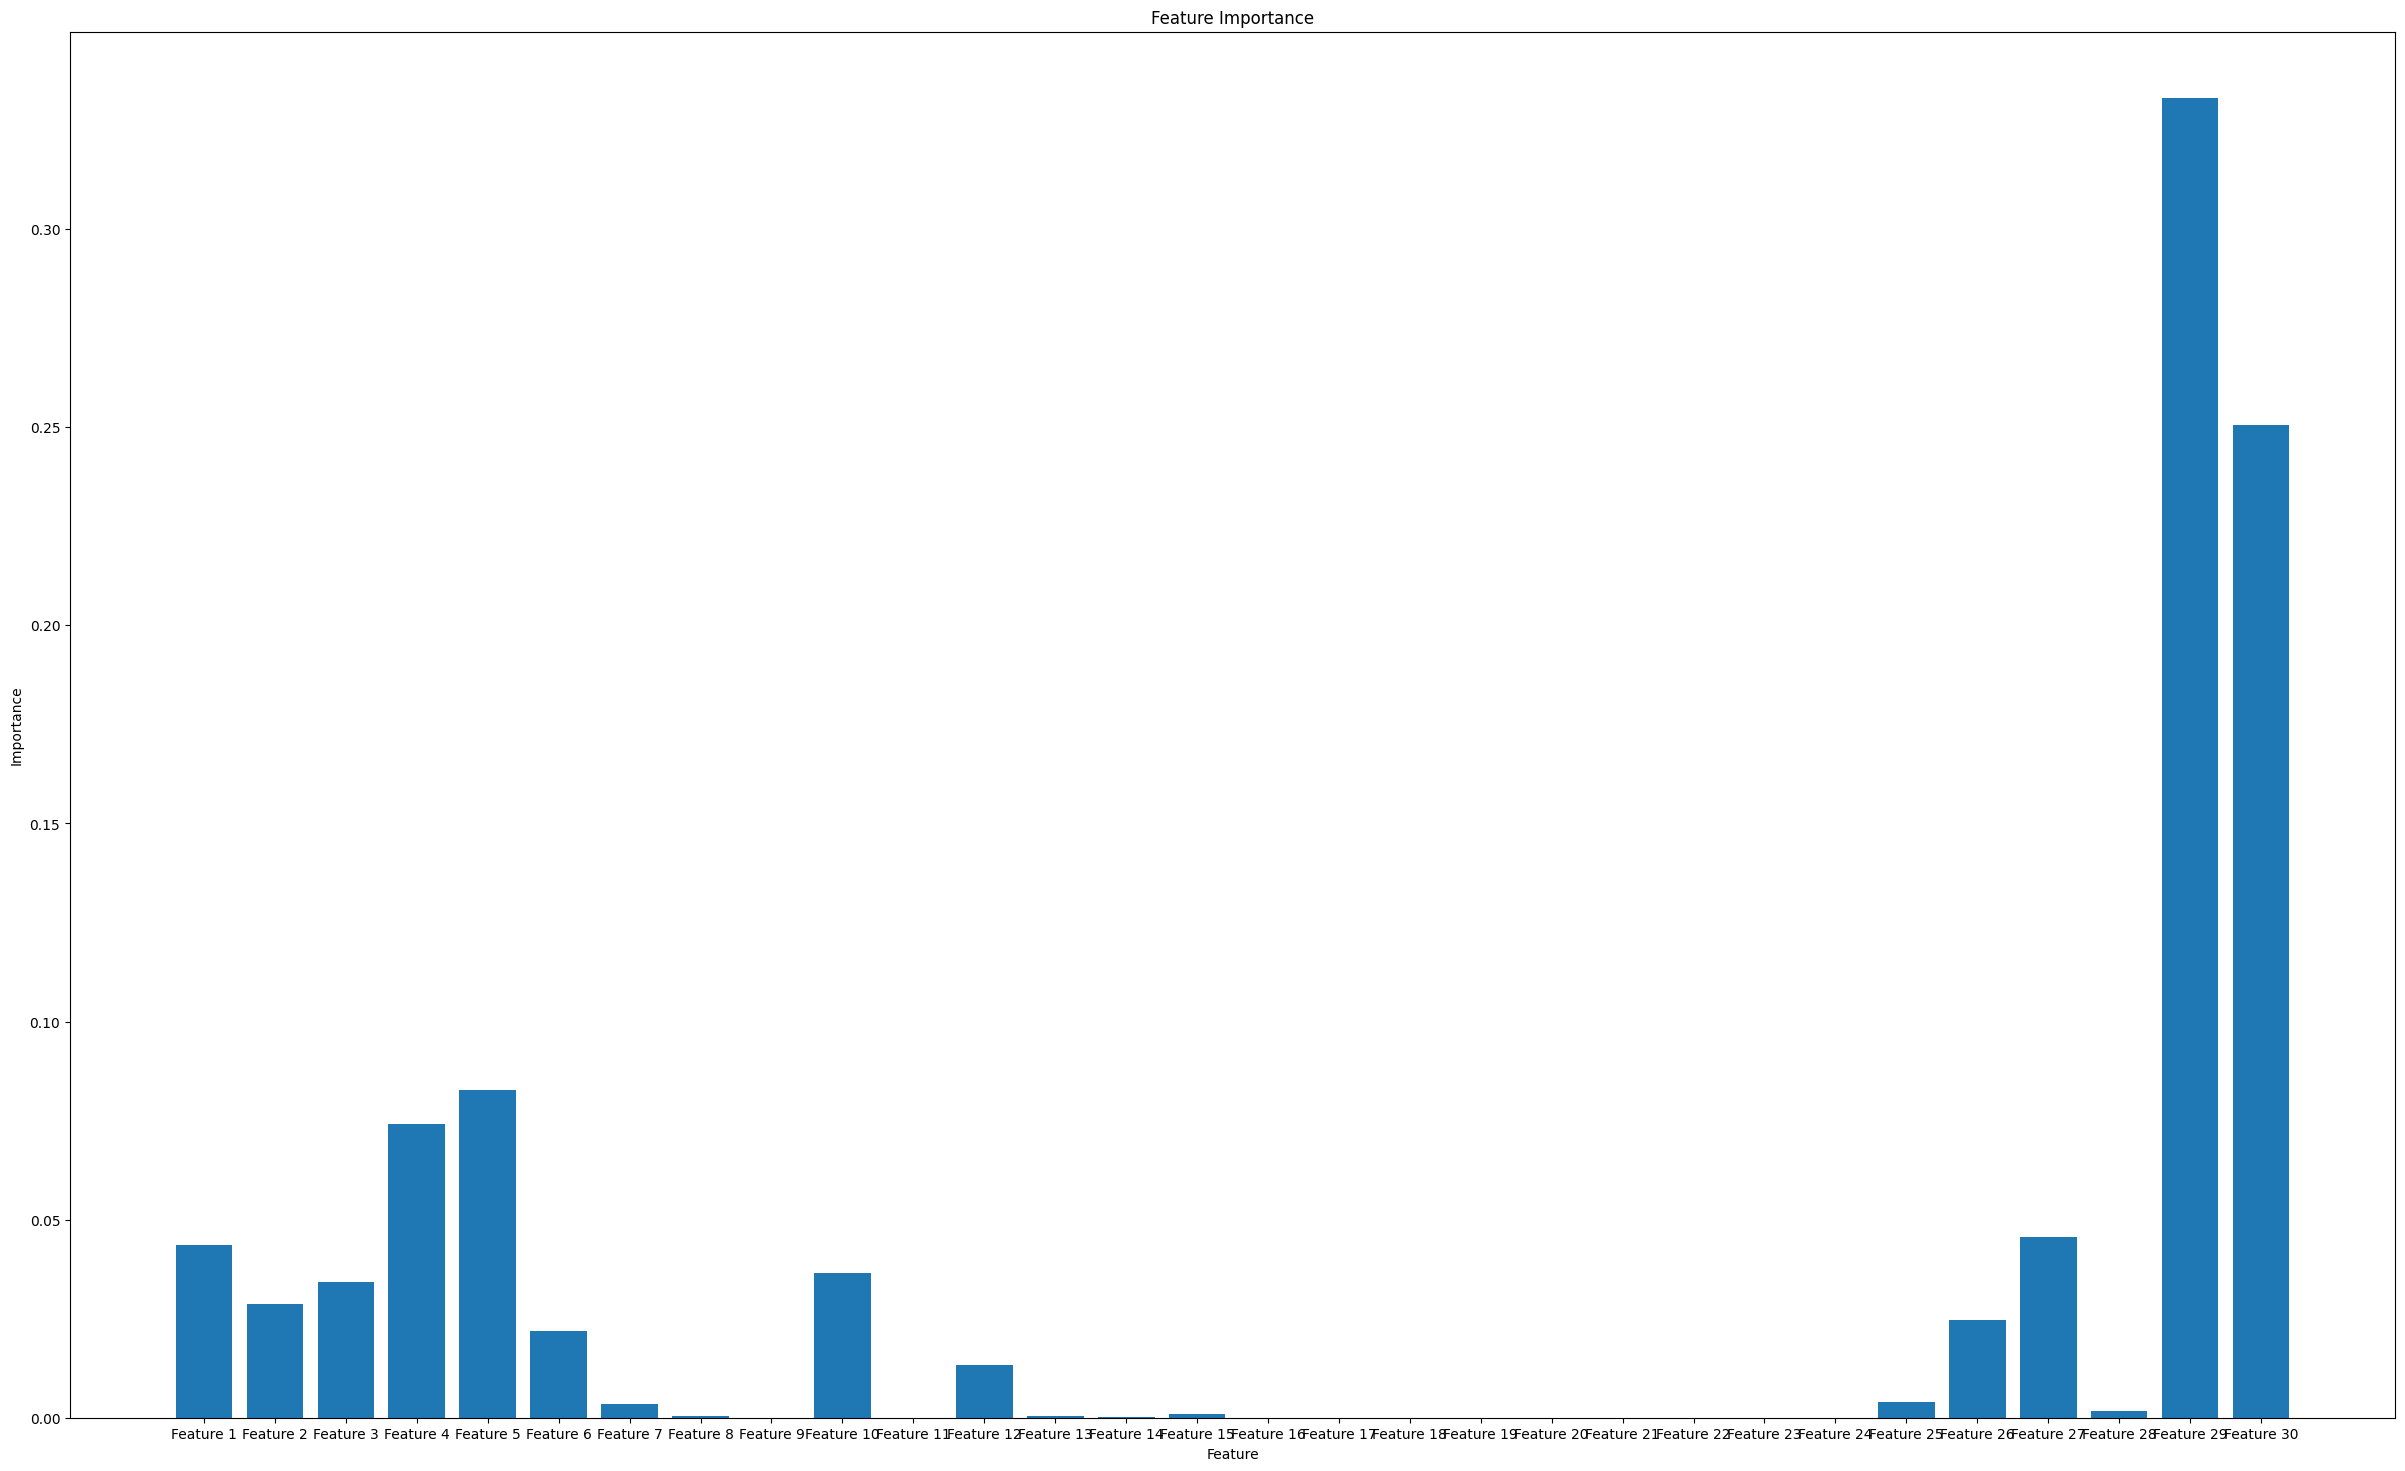

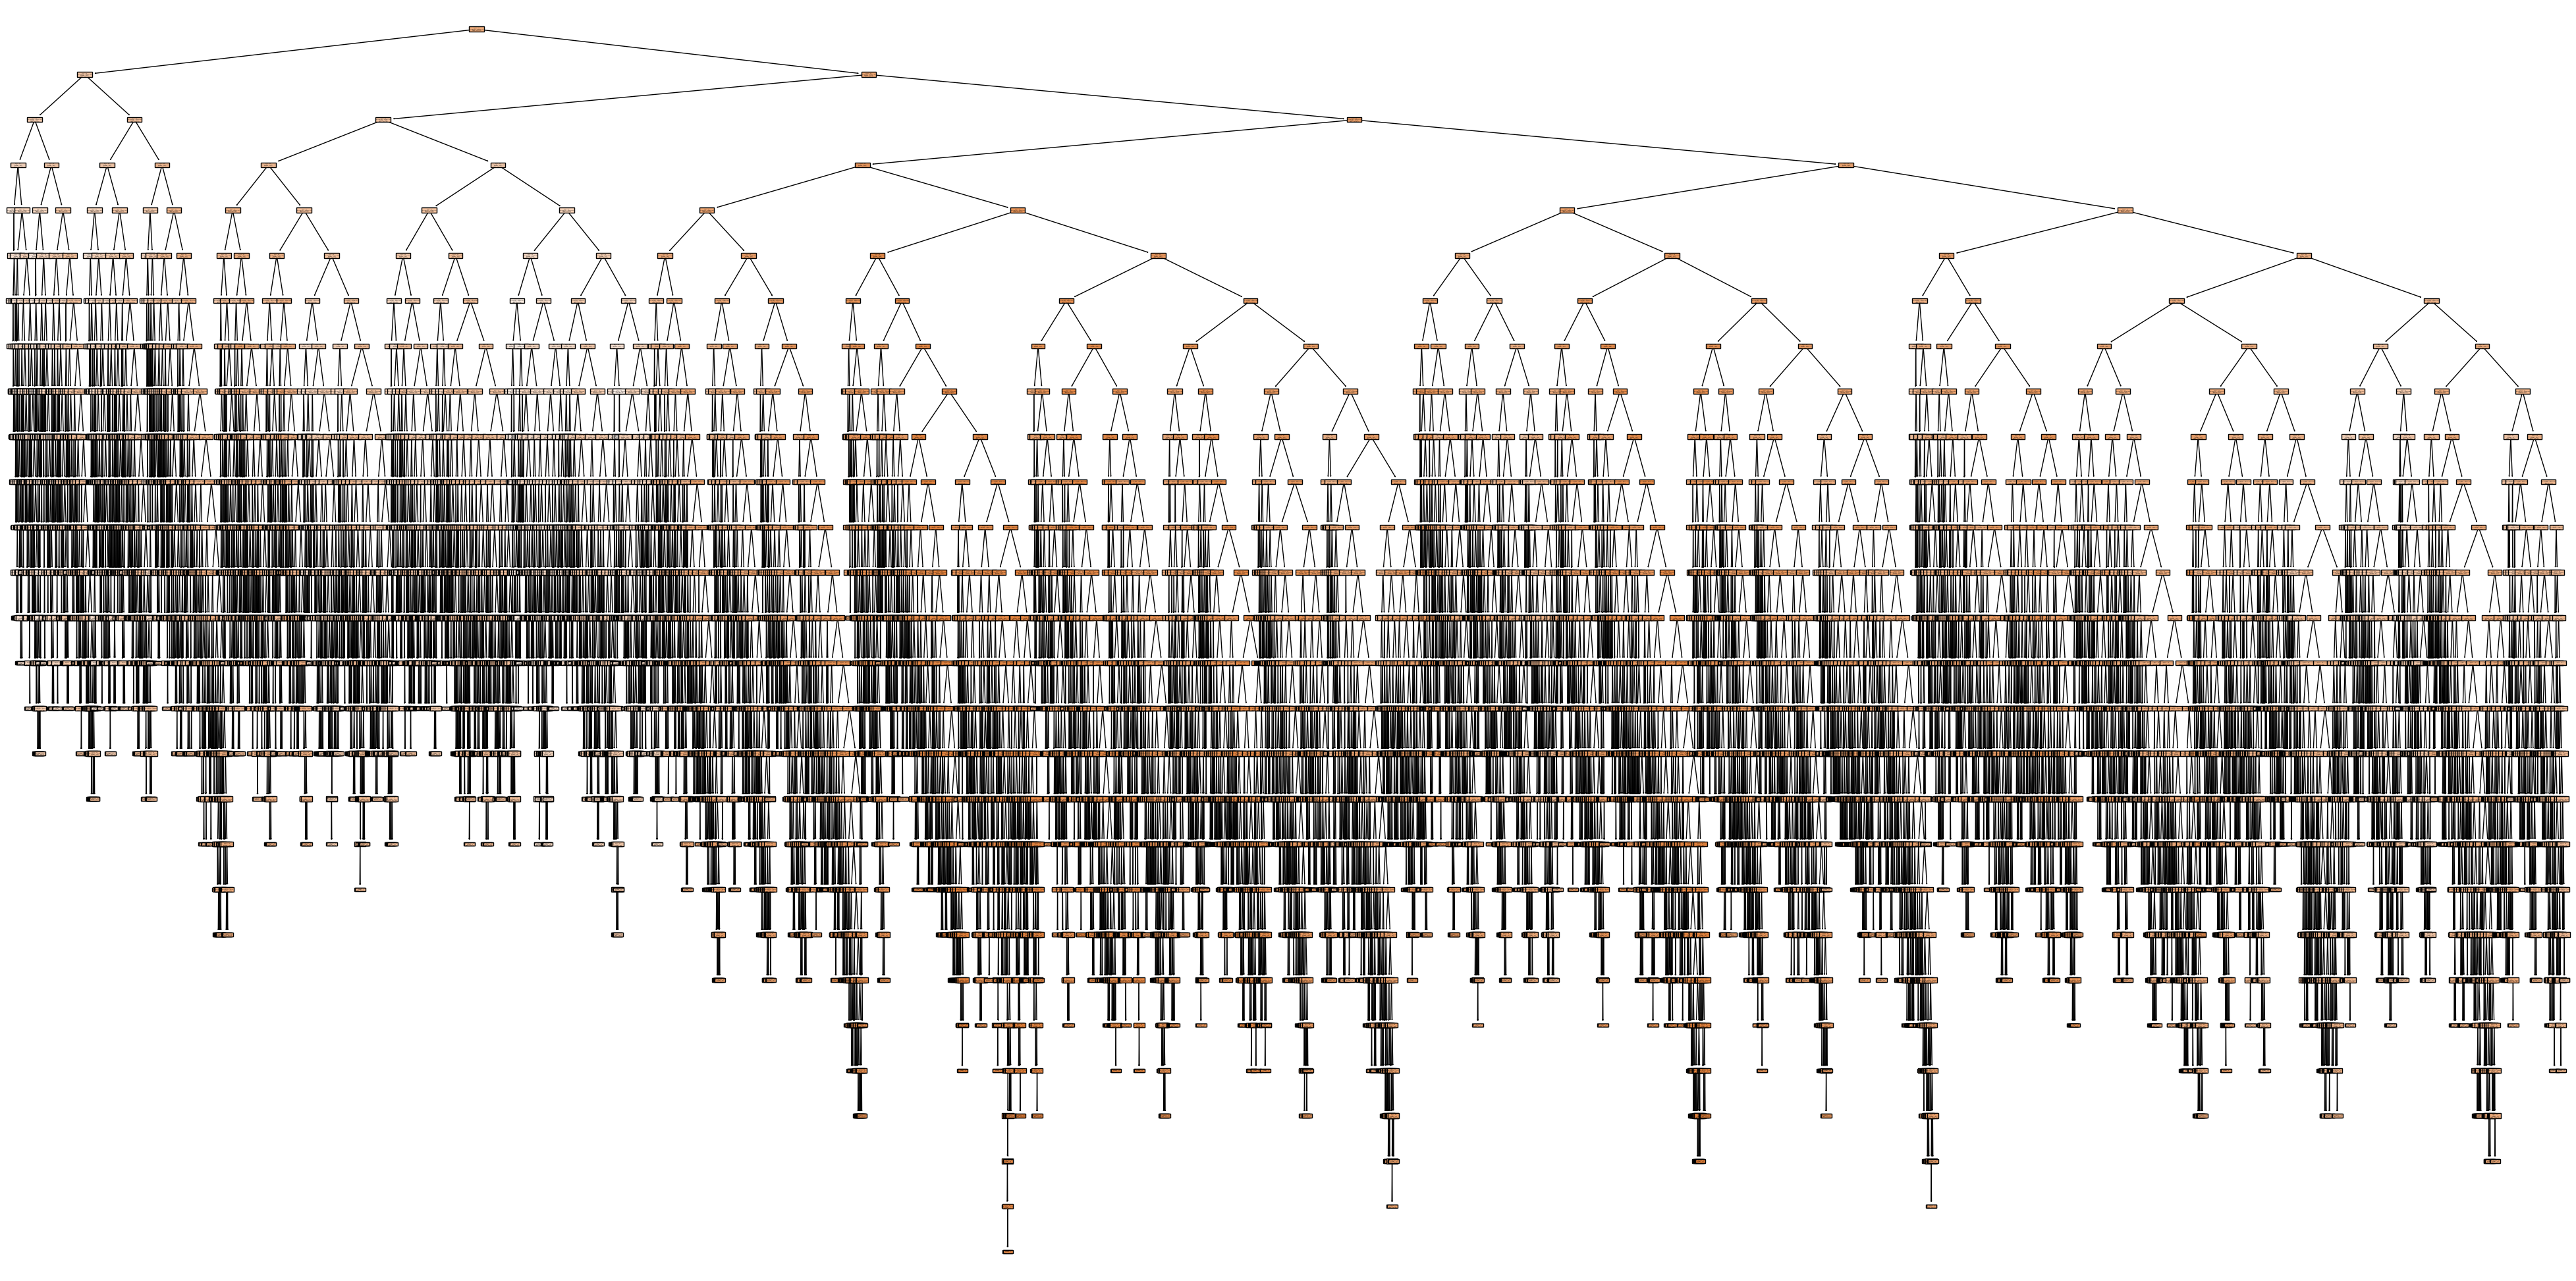

['model\\model-judgetree.pkl']

In [8]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
# 创建并训练决策树回归模型
tree_model = DecisionTreeRegressor(random_state=42)
# 执行 K 折交叉验证
cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5)

# 输出每折交叉验证的评分
print("每折交叉验证的评分:", cv_scores)

# 输出交叉验证评分的平均值
print("交叉验证评分的平均值:", np.mean(cv_scores))
tree_model.fit(X_train, y_train)

# 在测试集上评估模型性能
tree_score = tree_model.score(X_test, y_test)
print("决策树模型性能评分:", tree_score)

# 输出特征重要性
feature_importances = tree_model.feature_importances_
print("特征重要性:", feature_importances)
# 将特征重要性展平
feature_importances_flat = np.ravel(feature_importances)
# 可视化特征重要性
plt.figure(figsize=(30, 18))
plt.bar(range(len(feature_importances_flat)), feature_importances_flat, tick_label=[f'Feature {i}' for i in range(1, len(feature_importances_flat) + 1)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# 绘制决策树树状图
plt.figure(figsize=(50, 25))  # 设置图形大小
plot_tree(tree_model, filled=True)
plt.show()
# 在测试集上进行预测
y_pred = tree_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
# 模型存储
model_name = f"model\\model-judgetree.pkl"
# 保存模型
import joblib
joblib.dump(tree_model, model_name)

##### 梯度提升树

每折交叉验证的评分: [0.9989604  0.99872324 0.99871912 0.99863552 0.9988842 ]
交叉验证评分的平均值: 0.9987844960118896
梯度提升树模型性能评分: 0.998773850388773
特征重要性: [5.83507379e-02 3.16626492e-02 1.21197431e-02 7.53047254e-02
 7.54225974e-02 2.22281537e-02 2.71970449e-03 2.06484527e-04
 7.83651501e-05 3.22531350e-02 7.56341751e-05 1.08237777e-02
 1.81927827e-04 1.07663741e-04 6.37899272e-04 2.53757970e-06
 1.98368194e-06 1.04786591e-06 3.09376763e-08 1.39526635e-08
 9.19929212e-09 0.00000000e+00 9.10071315e-09 1.62074791e-08
 3.73904728e-02 8.21605390e-02 2.14041849e-02 3.30048266e-02
 2.84506205e-01 2.19354924e-01]


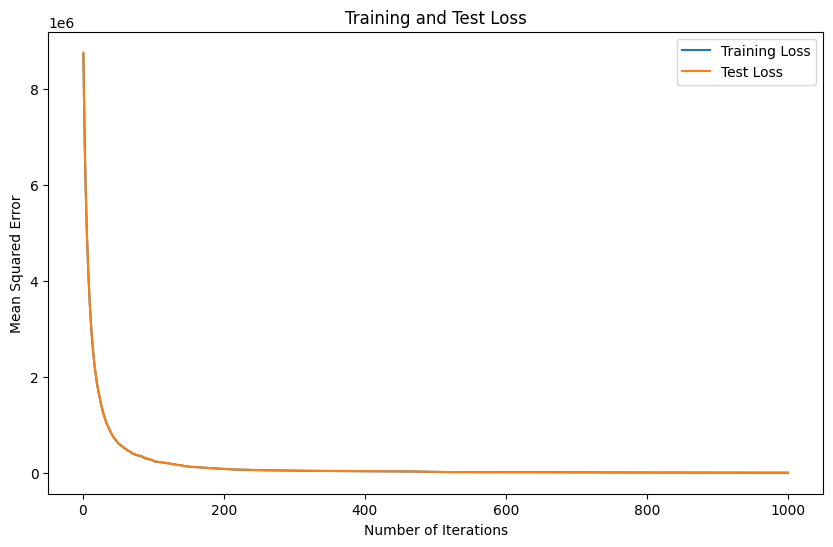

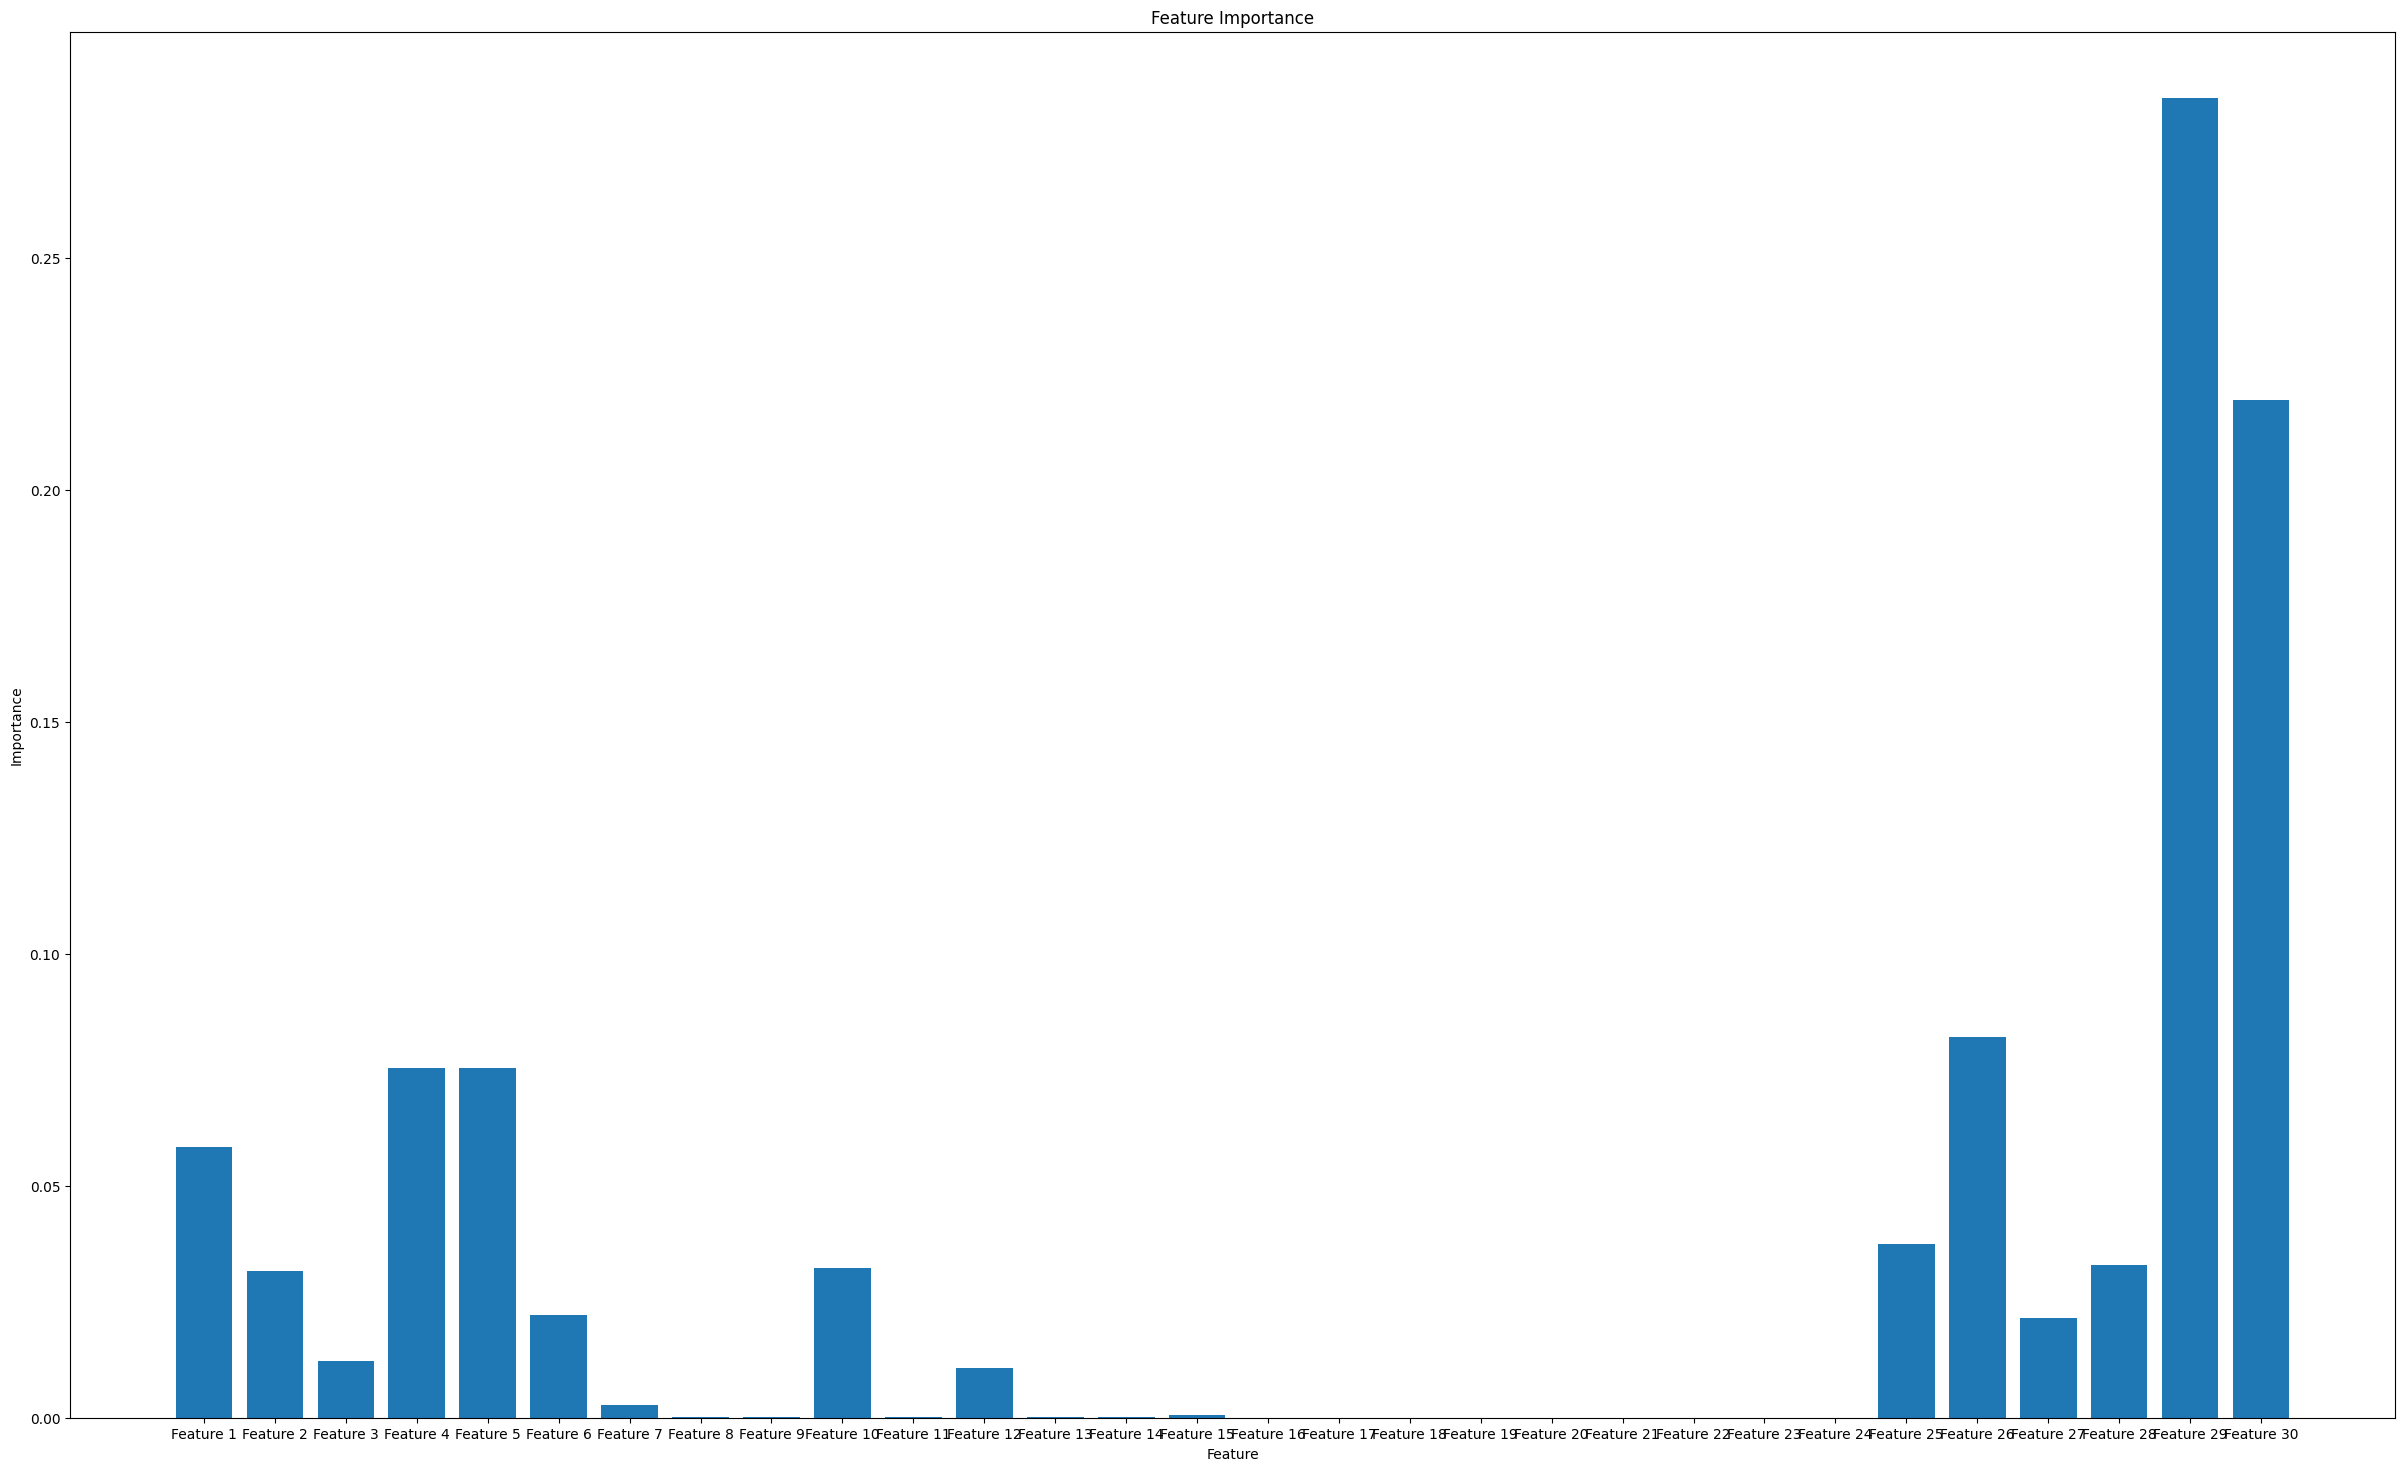

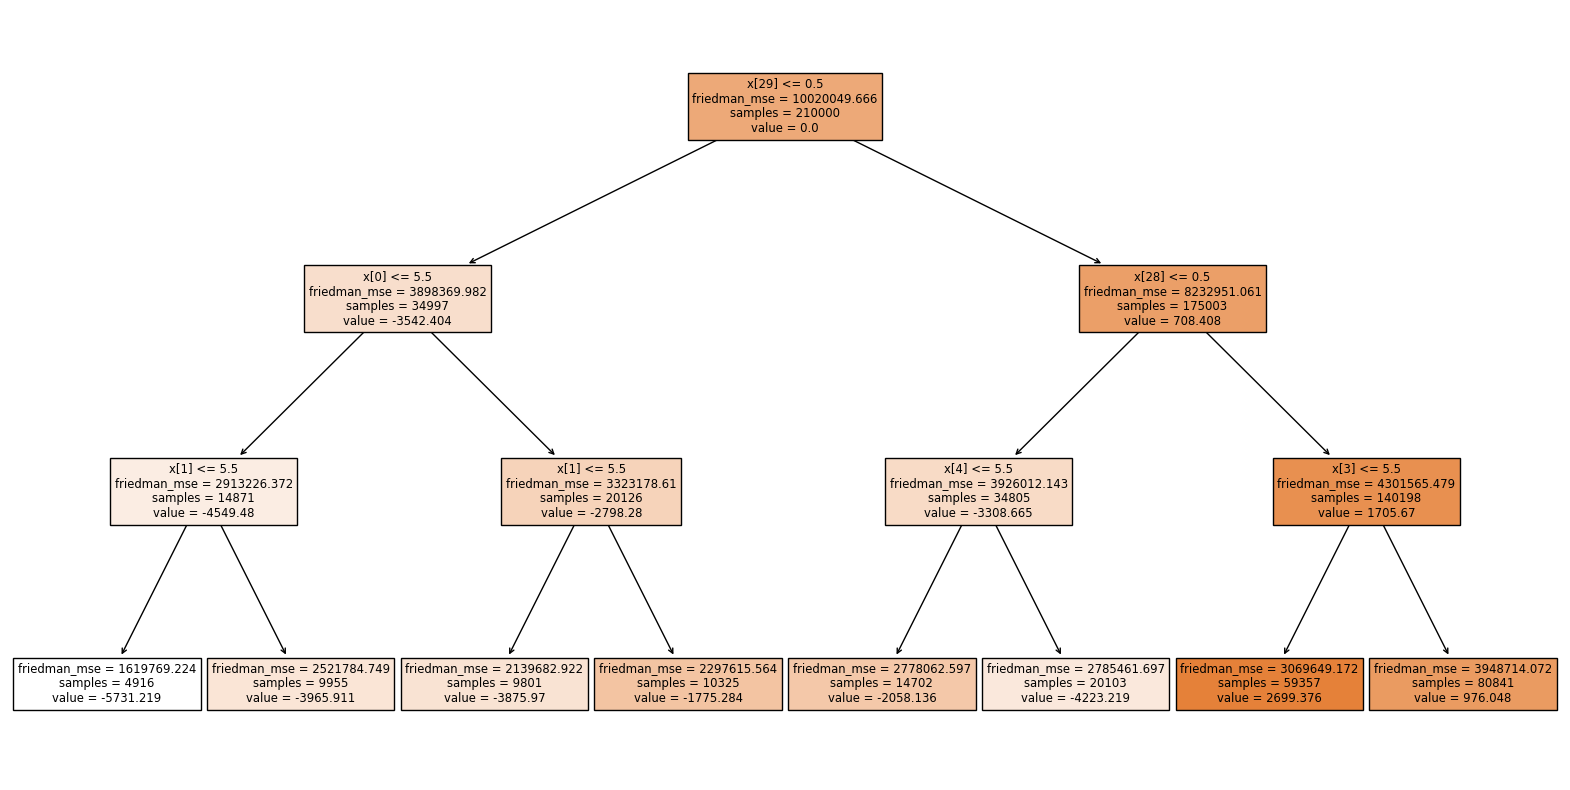

['model\\model-gbtree.pkl']

In [9]:
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
# 设置迭代次数为100
n_estimators = 1000

# 创建并训练梯度提升树回归模型
gb_model = GradientBoostingRegressor(n_estimators=n_estimators, random_state=42)
# 执行 K 折交叉验证
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)

# 输出每折交叉验证的评分
print("每折交叉验证的评分:", cv_scores)

# 输出交叉验证评分的平均值
print("交叉验证评分的平均值:", np.mean(cv_scores))
gb_model.fit(X_train, y_train)

# 在测试集上评估模型性能
gb_score = gb_model.score(X_test, y_test)
print("梯度提升树模型性能评分:", gb_score)

# 输出特征重要性
feature_importances = gb_model.feature_importances_
print("特征重要性:", feature_importances)

# 计算每轮迭代的损失值
train_loss = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(X_train)):
    train_loss[i] = mean_squared_error(y_train, y_pred)

test_loss = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(X_test)):
    test_loss[i] = mean_squared_error(y_test, y_pred)
# 在测试集上进行预测
y_pred = gb_model.predict(X_test)

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, gb_model.n_estimators + 1), train_loss, label='Training Loss')
plt.plot(np.arange(1, gb_model.n_estimators + 1), test_loss, label='Test Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 可视化特征重要性
plt.figure(figsize=(30, 18))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=[f'Feature {i}' for i in range(1, len(feature_importances) + 1)])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
# 获取第一棵决策树
first_tree = gb_model.estimators_[0, 0]  # 获取第一棵树（索引为[0, 0]）

# 绘制第一棵决策树的树状图
plt.figure(figsize=(20, 10))  # 设置图形大小
plot_tree(first_tree, filled=True)
plt.show()


# 模型存储
model_name = f"model\\model-gbtree.pkl"
# 保存模型
import joblib
joblib.dump(gb_model, model_name)


##### 线性回归

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"均方误差为: {mse}")
print(f"模型的系数为: {model.coef_}")
print(f"模型的截距为: {model.intercept_}")
# 模型存储
model_name = f"model\\model-Linear.pkl"
# 保存模型
import joblib
joblib.dump(model, model_name)


均方误差为: 1074906.508561111
模型的系数为: [ 7.63331256e+12  7.63331256e+12  7.63331256e+12  7.63331256e+12
  7.63331256e+12  7.63331256e+12  3.83484665e+14  3.83484665e+14
  3.83484665e+14  3.83484665e+14  3.83484665e+14  3.83484665e+14
 -1.44818220e+14 -1.44818220e+14 -1.44818220e+14 -1.44818220e+14
 -1.44818220e+14 -1.44818220e+14  2.53430448e+15  2.53430448e+15
  2.53430448e+15  2.53430448e+15  2.53430448e+15  2.53430448e+15
 -1.37810888e+15 -1.37810888e+15 -1.37810888e+15 -1.37810888e+15
 -1.37810888e+15 -1.37810888e+15]
模型的截距为: -2.4188457990496704e+16


['model\\model-Linear.pkl']

##### 模型性能评估

读取全部模型，构建模型列表

In [2]:
import joblib
from scipy.optimize import basinhopping
import numpy as np
model_filenames = ['model\\model-gbtree.pkl', 'model\\model-judgetree.pkl', 'model\\model-Linear.pkl']
models = [joblib.load(name) for name in model_filenames]

从全部输入中读取2000个输入，构建准确率曲线图

In [3]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
FIX_ALL_ANSWER = load_all_chunks(input_directory)

In [4]:
print(FIX_ALL_ANSWER.shape)
FIX_ALL_ANSWER=FIX_ALL_ANSWER.reshape(10077696,30)
print(FIX_ALL_ANSWER[0])

(10077696, 5, 6)
[3 6 6 6 6 6 1 3 3 3 3 3 2 4 4 4 4 4 1 2 2 2 2 2 0 1 1 1 1 1]


随机选取2000个输入作为验证

In [5]:
Input_Example=[]
for i in range(1):
    np.random.shuffle(FIX_ALL_ANSWER)

In [6]:
for i in range(2000):
    Input_Example.append(FIX_ALL_ANSWER[i])

In [7]:
print(Input_Example)

[array([6, 6, 3, 6, 6, 6, 3, 3, 3, 2, 3, 2, 4, 4, 2, 4, 4, 4, 2, 1, 2, 2,
       2, 2, 1, 1, 0, 1, 1, 1]), array([6, 5, 5, 6, 5, 6, 2, 3, 3, 2, 3, 3, 4, 3, 4, 3, 4, 4, 2, 2, 2, 1,
       2, 2, 1, 0, 1, 1, 1, 1]), array([6, 6, 6, 5, 6, 4, 3, 3, 2, 2, 3, 3, 4, 3, 4, 4, 3, 4, 2, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 0]), array([6, 6, 5, 6, 5, 5, 3, 3, 2, 3, 2, 3, 4, 4, 3, 3, 4, 4, 2, 2, 2, 1,
       2, 2, 1, 1, 0, 1, 1, 1]), array([5, 6, 5, 6, 6, 5, 2, 3, 3, 3, 2, 3, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2,
       2, 1, 1, 0, 1, 1, 1, 1]), array([5, 5, 5, 6, 6, 6, 3, 3, 3, 2, 3, 2, 3, 4, 3, 4, 4, 4, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 1, 0]), array([6, 5, 5, 6, 6, 5, 3, 3, 3, 3, 2, 2, 4, 3, 3, 4, 4, 4, 2, 2, 1, 2,
       2, 2, 1, 1, 1, 0, 1, 1]), array([5, 6, 6, 5, 6, 5, 3, 3, 2, 2, 3, 3, 4, 4, 3, 4, 4, 3, 2, 1, 2, 2,
       2, 2, 0, 1, 1, 1, 1, 1]), array([5, 6, 6, 5, 6, 5, 3, 3, 2, 3, 3, 2, 4, 4, 3, 4, 3, 4, 2, 2, 2, 2,
       1, 2, 1, 1, 1, 1, 0, 1]), array([6, 4, 5, 6, 6, 6, 3, 3, 3, 2, 3, 2, 3,

用准确率衡量模型的准确率

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


0.9991329972731919


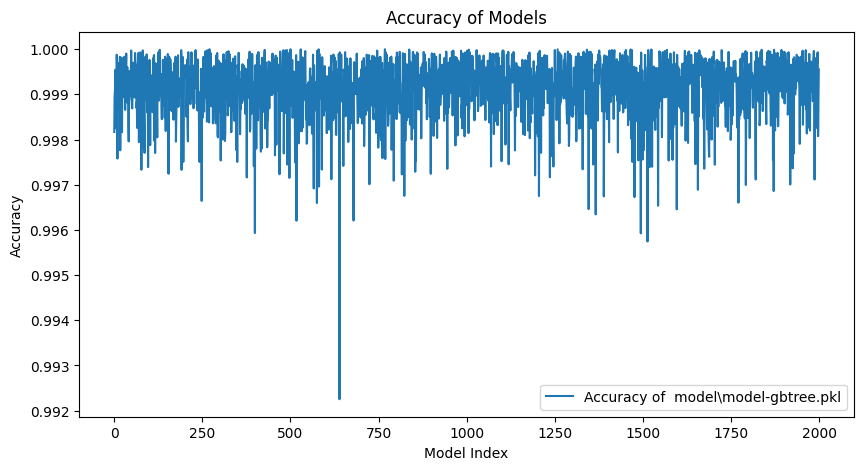

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


0.9999810050602044


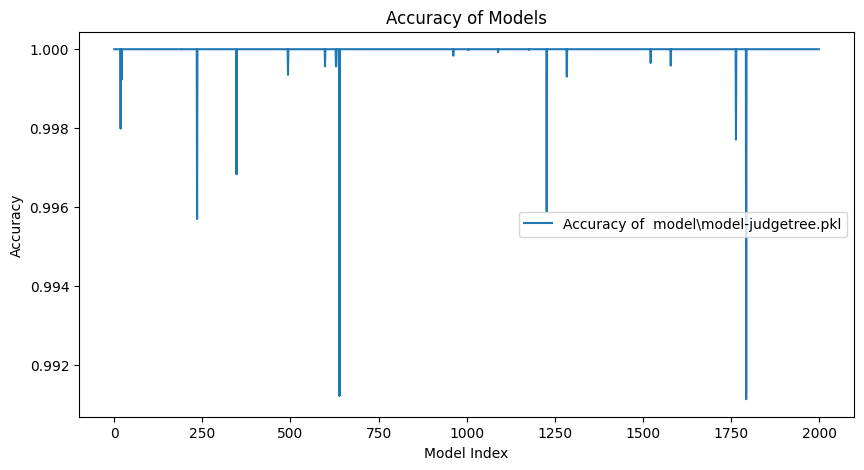

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


0.991710851006345


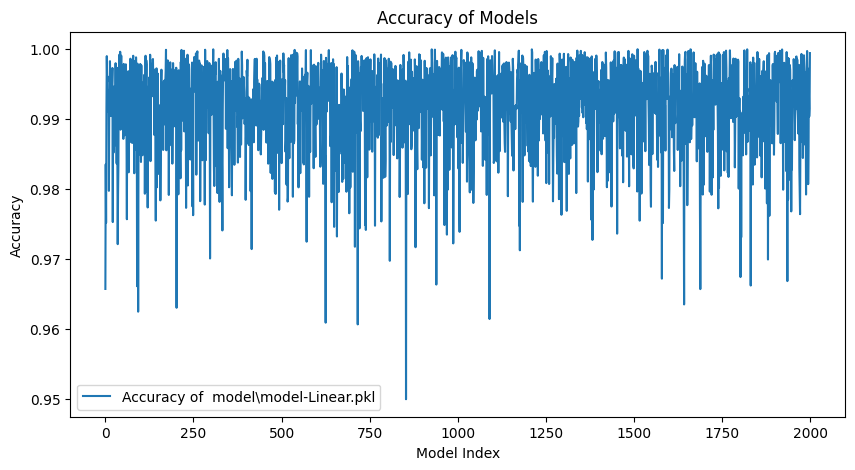

In [8]:
import matplotlib.pyplot as plt
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    return transposed_matrix
def calculate_accuracy(y_true, y_pred):
    mse=[]
    for i in range(len(y_true)):
        mse.append(min(y_true[i],y_pred[i])/max(y_true[i],y_pred[i]))
    return mse
from core import LinearProblem
for i in range(len(models)):
    Input_Example=np.array(Input_Example)
    now_model=models[i]
    Answer_predict=[]
    if i!=3:
        Answer_predict=now_model.predict(Input_Example)
    else:
        constant_value = -3.148e+10
        constant_column = np.full((Input_Example.shape[0], 1), constant_value)
        # 垂直堆叠X和constant_column，得到新的输入数组
        Input_Example1 = np.concatenate((Input_Example, constant_column), axis=1)
        Answer_predict=now_model.predict(Input_Example1)
    problem=LinearProblem.LinearCore()
    Answer_exact=[]
    for j in range(2000):
        temp=Input_Example[j].reshape(5,6).tolist()
        temp=transpose_list(temp)
        problem.reset_machine(transpose_list(Input_Example[j].reshape(5,6).tolist()))
        Answer_exact.append(problem.solveP())
    Answer_exact=np.array(Answer_exact)
    # 计算准确率（这里使用MSE作为准确率的衡量标准）
    accuracy = calculate_accuracy(Answer_exact, Answer_predict)
    print(sum(accuracy)/len(accuracy))
    # 绘制准确率曲线
    plt.figure(figsize=(10, 5))
    plt.plot(accuracy, label=f'Accuracy of  {model_filenames[i]}')
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy of Models')
    plt.legend()
    plt.show()



### 用不同的模型求解本问题

In [9]:
max_fit=0
max_array=[]

In [10]:
import os
import pickle
import numpy as np

def load_all_chunks(input_dir):
    all_chunks = []
    for filename in os.listdir(input_dir):
        if filename.endswith('.pkl'):
            filepath = os.path.join(input_dir, filename)
            with open(filepath, 'rb') as f:
                chunk = pickle.load(f)
            all_chunks.append(chunk)
    merged_data = np.concatenate(all_chunks, axis=0)
    return merged_data
input_directory = "distributed_storage"
DATA = load_all_chunks(input_directory)
DATA=DATA.reshape(-1,30)

In [11]:
print(DATA[0])

[3 6 6 6 6 6 1 3 3 3 3 3 2 4 4 4 4 4 1 2 2 2 2 2 0 1 1 1 1 1]


用不同的模型进行预测

In [12]:
def transpose_list(matrix):
    if not matrix:
        return []
    
    rows = len(matrix)
    cols = len(matrix[0])
    
    transposed_matrix = []
    for j in range(cols):
        transposed_row = []
        for i in range(rows):
            transposed_row.append(matrix[i][j])
        transposed_matrix.append(transposed_row)
    return transposed_matrix
from core import LinearProblem
problem=LinearProblem.LinearCore()
for i in range(len(models)):
    model=models[i]
    PRE=model.predict(DATA)
    temp=np.unravel_index(np.argmax(PRE), PRE.shape)
    problem.reset_machine(transpose_list(DATA[temp].reshape(5,6).tolist()))
    print(temp,DATA[temp],PRE[temp],problem.solveP())

C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(4593261,) [6 6 6 4 5 6 3 3 3 1 3 3 4 4 4 2 4 4 2 1 2 2 2 2 1 1 1 0 1 1] 105441.82434683102 104728.0


C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(4566615,) [6 6 6 4 5 6 2 2 3 3 3 3 3 3 4 4 4 4 1 2 2 2 2 2 1 1 1 0 1 1] 105007.5 105007.5
(4537543,) [6 6 6 3 6 6 3 3 1 3 3 3 4 4 4 2 4 4 2 2 2 1 2 2 1 0 1 1 1 1] 106000.0 104070.0


C:\Users\12780\AppData\Roaming\Python\Python39\site-packages\pulp\pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


以上输出为最终预测结果，最后一项为预测的最大机器排布的实际最大利润

[6 6 6 4 5 6 2 2 3 3 3 3 3 3 4 4 4 4 1 2 2 2 2 2 1 1 1 0 1 1] 105007.5 为最终预测答案